In [1]:
import os,sys
sys.path.append('lcnn')

import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.postprocess import postprocess

In [2]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}

def c(x):
    # Function to convert scores to colors for visualization
    cmap = plt.get_cmap("jet")
    norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    return sm.to_rgba(x)

def load_model(config_path = "lcnn/config/wireframe.yaml", checkpoint_path = "lcnn/190418-201834-f8934c6-lr4d10-312k.pth.tar"):
    C.update(C.from_yaml(filename=config_path))
    M.update(C.model)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    model = lcnn.models.hg(
        depth=M.depth,
        head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
        num_stacks=M.num_stacks,
        num_blocks=M.num_blocks,
        num_classes=sum(sum(M.head_size, [])),
    )
    model = MultitaskLearner(model)
    model = LineVectorizer(model)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()

    return model, device

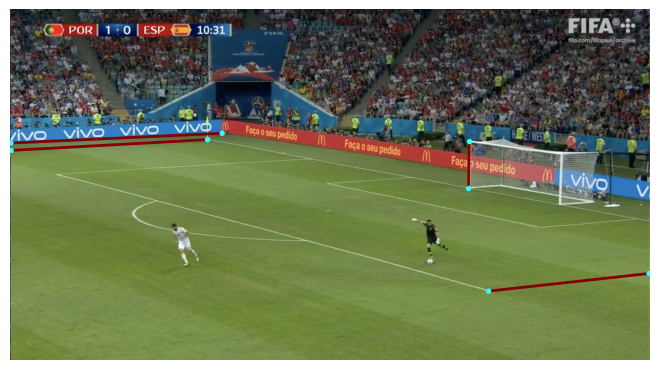

In [7]:
image_path = "data/images/test/test.jpg"
model, device = load_model()
im = skimage.io.imread(image_path)
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

# Model inference
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

# Post-process the output
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()

# Remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

line_coordinates = []
threshold = 0.97
for (a, b), score in zip(nlines, nscores):
    if score < threshold:
        continue
    x1, y1 = a  # Starting point of the line
    x2, y2 = b  # Ending point of the line
    line_coordinates.append((x1, y1, x2, y2))

# Visualization and saving the results
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < threshold:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()